<a href="https://colab.research.google.com/github/1234sb-star/customer-segmentation-recommendation/blob/main/Fraud_detection_in_financial_Transaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/deeple/fraud_data.csv"
df = pd.read_csv(file_path)

In [ ]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TransactionID     500 non-null    int64  
 1   Amount            475 non-null    float64
 2   Time              500 non-null    int64  
 3   Location          475 non-null    object 
 4   MerchantCategory  500 non-null    object 
 5   CardHolderAge     476 non-null    float64
 6   IsFraud           500 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 27.5+ KB


,TransactionID,Amount,Time,CardHolderAge,IsFraud
count,500.000000,475.000000,500.000000,476.000000,500.000000
mean,250.500000,641.112753,41141.482000,47.518908,0.054000
std,144.481833,1044.448065,25614.468967,18.677362,0.226244
min,1.000000,6.060000,55.000000,5.000000,0.000000
25%,125.750000,243.780000,18726.250000,32.000000,0.000000
50%,250.500000,518.810000,40772.000000,47.000000,0.000000
75%,375.250000,776.000000,63463.250000,63.000000,0.000000
max,500.000000,9691.578643,86066.000000,120.000000,1.000000


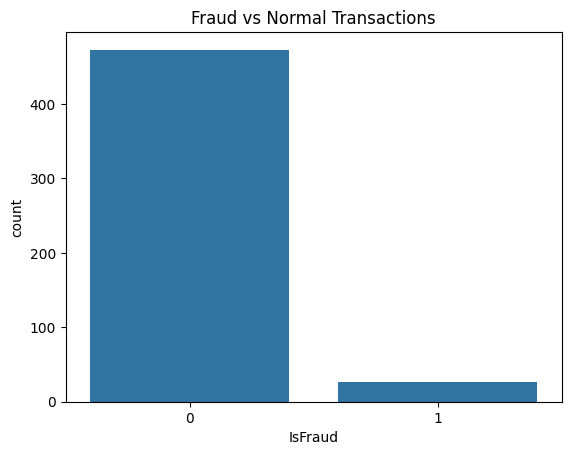

In [ ]:
# Check Fraud Distribution
df['IsFraud'].value_counts()
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='IsFraud', data=df)
plt.title("Fraud vs Normal Transactions")
plt.show()


In [ ]:
# Handle Missing Values
df['Amount'].fillna(df['Amount'].median(), inplace=True)
df['CardHolderAge'].fillna(df['CardHolderAge'].median(), inplace=True)
df['Location'].fillna(df['Location'].mode()[0], inplace=True)


/tmp/ipython-input-3420795444.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Amount'].fillna(df['Amount'].median(), inplace=True)
/tmp/ipython-input-3420795444.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [ ]:
# Drop Irrelevant Column
df.drop('TransactionID', axis=1, inplace=True)


In [ ]:
# Encode Categorical Features
df = pd.get_dummies(df, columns=['Location', 'MerchantCategory'], drop_first=True)


In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Amount', 'Time', 'CardHolderAge']] = scaler.fit_transform(
    df[['Amount', 'Time', 'CardHolderAge']]
)


In [ ]:
# train test split
from sklearn.model_selection import train_test_split

X = df.drop('IsFraud', axis=1)
y = df['IsFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [ ]:
# Handle Class Imbalance (SMOTE)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_res.value_counts())


Before SMOTE:
 IsFraud
0    355
1     20
Name: count, dtype: int64
After SMOTE:
 IsFraud
1    355
0    355
Name: count, dtype: int64


In [ ]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)

y_pred_lr = lr.predict(X_test)
print("Logistic Regression Results:\n")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Results:

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       118
           1       0.04      0.14      0.06         7

    accuracy                           0.75       125
   macro avg       0.49      0.47      0.46       125
weighted avg       0.89      0.75      0.81       125



In [ ]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test)
print("Random Forest Results:\n")
print(classification_report(y_test, y_pred_rf))


Random Forest Results:

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       118
           1       0.00      0.00      0.00         7

    accuracy                           0.88       125
   macro avg       0.47      0.47      0.47       125
weighted avg       0.89      0.88      0.88       125



In [ ]:
# Isolation forest
from sklearn.ensemble import IsolationForest
import numpy as np

iso = IsolationForest(contamination=0.15, random_state=42)
iso.fit(X_train)

y_pred_iso = iso.predict(X_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

print("Isolation Forest Results:\n")
print(classification_report(y_test, y_pred_iso))


Isolation Forest Results:

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       118
           1       0.05      0.14      0.07         7

    accuracy                           0.80       125
   macro avg       0.50      0.49      0.48       125
weighted avg       0.89      0.80      0.84       125



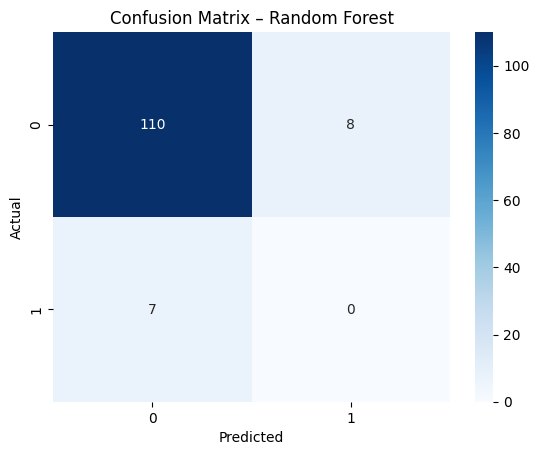

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
feature_importance = pd.Series(
    rf.feature_importances_, index=X.columns
).sort_values(ascending=False)

feature_importance.head(10)


,0
CardHolderAge,0.230387
Time,0.224329
Amount,0.180328
Location_New York,0.135236
Location_Los Angeles,0.048364
MerchantCategory_Groceries,0.046234
MerchantCategory_Entertainment,0.033894
MerchantCategory_Electronics,0.028146
Location_Houston,0.026947
Location_Miami,0.025520


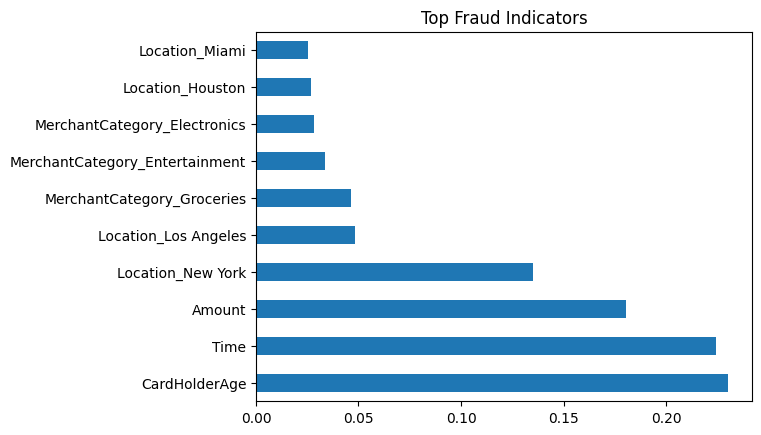

In [ ]:
feature_importance.head(10).plot(kind='barh')
plt.title("Top Fraud Indicators")
plt.show()
